In [9]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Cargar datos
file_path = "sample_dbs_tunning.csv"
df = pd.read_csv(file_path, low_memory=False)

In [4]:
# Preprocesamiento
df = df.drop(columns=['Unnamed: 0', 'Date', 'Portfolio_Returns'])
X = df.drop(columns=['Sortino_Ratio'])
y = df['Sortino_Ratio']
X_columns = X.columns  # Guardar nombres originales

In [5]:
# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# División de datos
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)

# Grid de hiperparámetros
C_values = [10]
epsilon_values = [0.1]
kernel_types = ['rbf']
results = []

In [8]:
# Búsqueda por rejilla
for C, epsilon, kernel in itertools.product(C_values, epsilon_values, kernel_types):
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({'C': C, 'epsilon': epsilon, 'kernel': kernel, 'mse': mse, 'r2': r2})

results_df = pd.DataFrame(results)

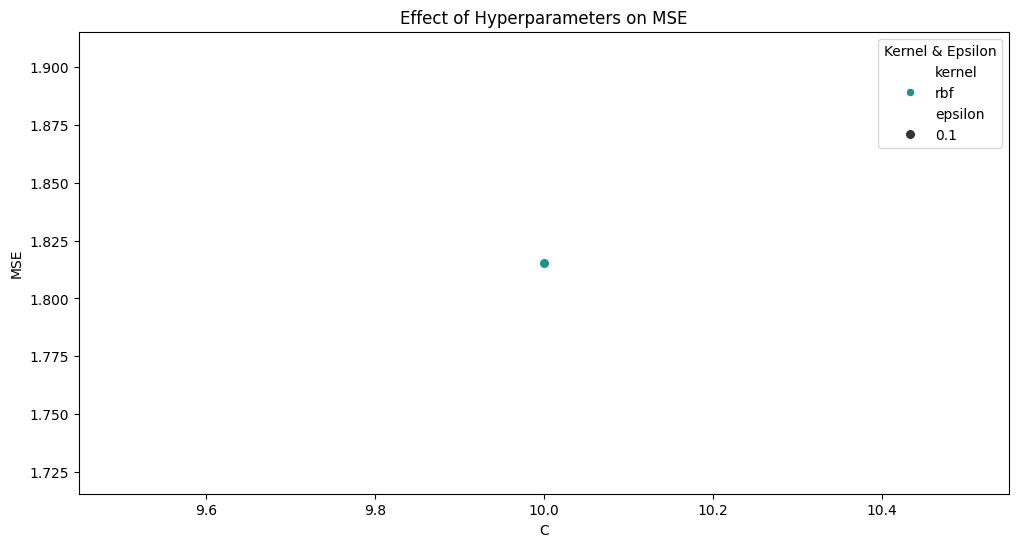

In [10]:
# Visualización de resultados
plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x='C', y='mse', hue='kernel', size='epsilon', palette='viridis', sizes=(50, 200))
plt.title("Effect of Hyperparameters on MSE")
plt.xlabel("C")
plt.ylabel("MSE")
plt.legend(title="Kernel & Epsilon")
plt.show()

In [11]:
print("Resultados de la rejilla de hiperparámetros:")
print(results_df)

Resultados de la rejilla de hiperparámetros:
    C  epsilon kernel       mse        r2
0  10      0.1    rbf  1.815456 -0.097812


In [12]:
# === SHAP para el mejor modelo ===
best_params = results_df.sort_values(by="r2", ascending=False).iloc[0]
best_model = SVR(kernel=best_params['kernel'], C=best_params['C'], epsilon=best_params['epsilon'])
best_model.fit(X_train, y_train)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,np.int64(10)
,epsilon,np.float64(0.1)
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


100%|██████████| 50/50 [6:46:33<00:00, 487.86s/it]  


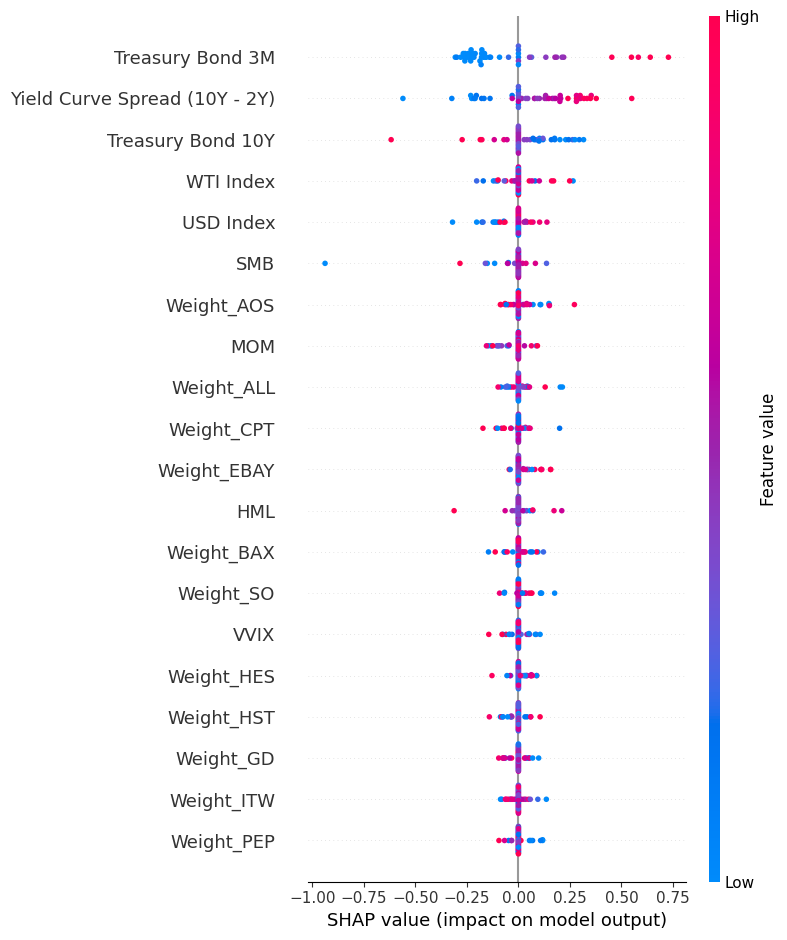

Importancia SHAP de los features:
                          feature  importance
21               Treasury Bond 3M    0.212062
23  Yield Curve Spread (10Y - 2Y)    0.177948
20              Treasury Bond 10Y    0.096425
22                      WTI Index    0.042911
24                      USD Index    0.042458
27                            SMB    0.041882
3                      Weight_AOS    0.035189
25                            MOM    0.029737
5                      Weight_ALL    0.025986
8                      Weight_CPT    0.022874
19                    Weight_EBAY    0.021852
28                            HML    0.021844
18                     Weight_BAX    0.021417
11                      Weight_SO    0.020738
26                           VVIX    0.019185
14                     Weight_HES    0.019097
0                      Weight_HST    0.019033
13                      Weight_GD    0.018932
10                     Weight_ITW    0.018212
17                     Weight_PEP    0.016275


In [13]:
# Reducir costo computacional: tomar muestra
X_sample = shap.sample(X_train, 100, random_state=0)
explainer = shap.KernelExplainer(best_model.predict, X_sample)
shap_values = explainer.shap_values(X_test[:50])

# SHAP summary plot
shap.summary_plot(shap_values, X_test[:50], feature_names=X_columns)

# === Selección de variables ===
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({'feature': X_columns, 'importance': mean_abs_shap})
shap_importance = shap_importance.sort_values(by='importance', ascending=False)
print("Importancia SHAP de los features:")
print(shap_importance)

In [14]:
# Umbral: promedio de importancias
threshold = shap_importance['importance'].mean()
selected_features = shap_importance[shap_importance['importance'] > threshold]['feature'].tolist()

print(f"Features seleccionados (umbral > {threshold:.4f}):")
print(selected_features)

Features seleccionados (umbral > 0.0363):
['Treasury Bond 3M', 'Yield Curve Spread (10Y - 2Y)', 'Treasury Bond 10Y', 'WTI Index', 'USD Index', 'SMB']


In [15]:
# Reentrenar modelo con solo esos features
X_selected = df[selected_features]
X_scaled_selected = scaler.fit_transform(X_selected)
X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(X_scaled_selected, y, test_size=0.3, random_state=42)
X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, test_size=0.5, random_state=42)

best_model.fit(X_train_s, y_train_s)
preds_new = best_model.predict(X_test_s)

In [16]:
print("Resultados tras limpieza de features:")
print("MSE:", mean_squared_error(y_test_s, preds_new))
print("R²:", r2_score(y_test_s, preds_new))

Resultados tras limpieza de features:
MSE: 1.4307890610353629
R²: 0.07076633982553548


(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 7.000e+00, 2.000e+00,
        1.000e+00, 4.000e+00, 3.000e+00, 8.000e+00, 8.000e+00, 1.500e+01,
        9.000e+00, 9.000e+00, 2.600e+01, 7.400e+01, 1.140e+02, 2.080e+02,
        2.940e+02, 6.030e+02, 1.158e+03, 2.222e+03, 4.410e+03, 7.931e+03,
        8.575e+03, 6.185e+03, 3.081e+03, 1.404e+03, 7.030e+02, 2.300e+02,
        1.380e+02, 9.400e+01, 4.500e+01, 5.600e+01, 1.800e+01, 5.000e+00,
        1.000e+01, 1.000e+00, 4.000e+00, 7.000e+00, 1.100e+01, 3.000e+00,
        2.000e+00, 3.000e+00]),
 array([-16.15058634, -15.61340795, -15.07622955, -14.53905116,
        -14.00187277, -13.46469437, -12.92751598, -12.39033758,
        -11.85315919, -11.31598079, -10.7788024 , -10.241624  ,
         -9.70444561,  -9.16726721,  -8.63008882,  -8.09291042,
         -7.55573203,  -7.01855364,  -6.48137524,  -5.94419685,
         -5.40701845,  -4.86984006,  -4.33266166,  -3.79

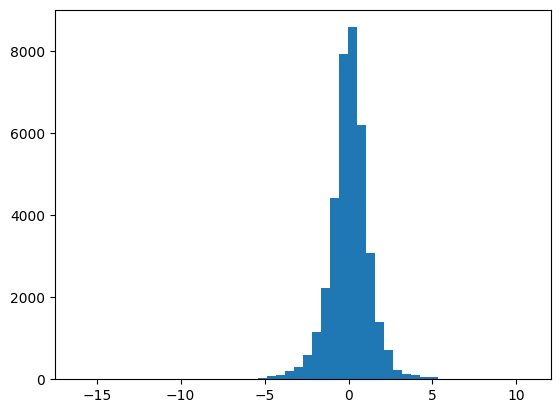

In [18]:
plt.hist(y, bins=50)